In [1]:
import matplotlib.pyplot as plt
import skimage.filters
import keras
import numpy
import cv2
import os

In [15]:
# Load input and output imgs

input_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\positive\A",
]
output_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\positive\B",
]
output_shape = (246, 246, 1)

from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range=(0.8,1),
    brightness_range=(0.5,1.5),
)

def normalize_img(img):
    img = img - img.min()
    img = img / img.max() if img.max() > 0 else img
    return img

def enhance_img(img, count):
    results = []
    iterator = generator.flow(img.reshape(1, *img.shape), seed=1)
    for i in range(count):
        result = next(iterator).reshape(img.shape)
        results = normalize_img(img)
        results.append(result)

    return results

def crop_img(img, shape):
    x_diff = (img.shape[0] - shape[0]) // 2
    y_diff = (img.shape[1] - shape[1]) // 2
    crop_img = img[ 
        x_diff : x_diff + shape[0],
        y_diff : y_diff + shape[1],
    ]
    return crop_img

def bw_img(img):
    bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return bw_img.reshape(*bw_img.shape, 1)


def load_images(dirs, crop=None, BW=False, enhance=0):
    imgs = []

    for dir in dirs:
        for sub in os.walk(dir):
            subdir = sub[0]
            files = sub[2]
            for file in files:
                filepath = subdir + "\\" + file
                img = cv2.imread(filepath)
                if BW:
                    img = bw_img(img)
                if crop:
                    img = crop_img(img, crop)
                if enhance:
                    imgs.extend(enhance_img(img, enhance))
                else:
                    imgs.append(img)

    return numpy.array(imgs)


input_imgs = load_images(input_dirs, enhance=4)
input_shape = input_imgs[0].shape
output_imgs = load_images(output_dirs, enhance=4, crop=output_shape, BW=True)
output_shape = output_imgs[0].shape

print(input_shape, output_shape)
print(len(input_imgs))
print(input_imgs.max(), output_imgs.max())


(256, 256, 3) (246, 246, 1)
800
1.0 1.0


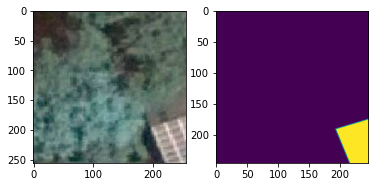

In [9]:
# Show the first pair in the dataset
index = 5

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(input_imgs[index])
axarr[1].imshow(output_imgs[index].reshape(*output_shape[:2]))

In [10]:
# Create a simple CNN model

from keras.models import Sequential
from keras import layers

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(7, 7), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(1, kernel_size=(3, 3), activation="sigmoid")
    ]
)

In [11]:
# Compile model and start training

batch_size = 10
epochs = 10

model.compile(optimizer="adam", loss="binary_crossentropy")
model.fit(input_imgs, output_imgs, batch_size=batch_size, epochs=epochs)

Epoch 1/10
80/80 [==============================] - 8s 91ms/step - loss: 0.3648
Epoch 2/10
80/80 [==============================] - 7s 90ms/step - loss: 0.2590
Epoch 3/10
80/80 [==============================] - 7s 91ms/step - loss: 0.2064
Epoch 4/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1948
Epoch 5/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1894
Epoch 6/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1903
Epoch 7/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1758
Epoch 8/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1657
Epoch 9/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1612
Epoch 10/10
80/80 [==============================] - 7s 91ms/step - loss: 0.1547


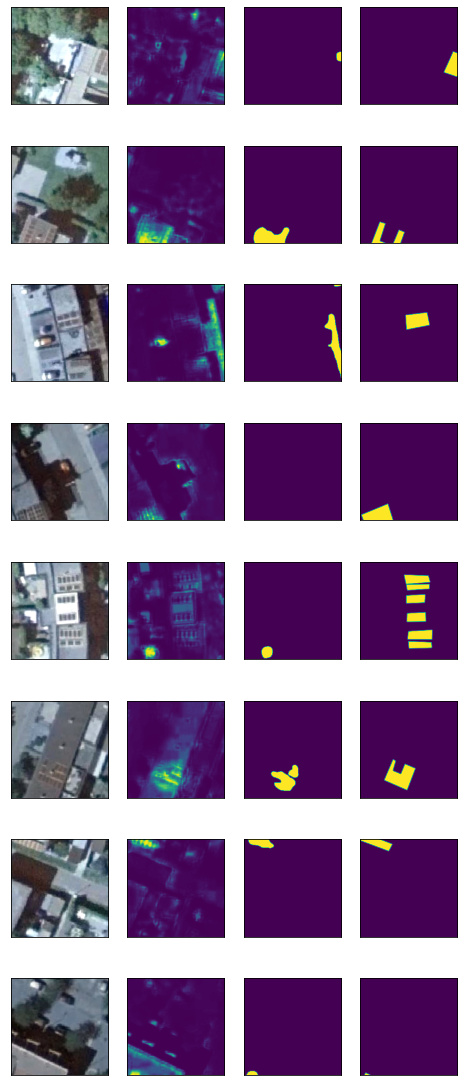

In [12]:
# Infer a result
image_indexes = [10,20,30,40,50,60,70,80]

def hide_axis(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def process_inference(img):
    sigma = 10
    mask = skimage.filters.gaussian(img, sigma=sigma)
    mask = mask > 0.3
    mask = skimage.filters.gaussian(mask, sigma=sigma)
    mask = mask > 0.02
    result = (img * mask) > 0.3
    result = skimage.filters.gaussian(result, sigma=sigma/2)
    result = result > 0.45
    return result

# Plotting
fig, axs = plt.subplots(len(image_indexes), 4)
fig.set_size_inches(8,20)

for i, index in enumerate(image_indexes):
    inp = input_imgs[index].reshape(1, 256, 256, 3)
    infer = model.predict(inp).reshape(246, 246)

    axs[i,0].imshow(input_imgs[index])
    axs[i,1].imshow(infer)
    axs[i,2].imshow(process_inference(infer))
    axs[i,3].imshow(output_imgs[index].reshape(246, 246))

    for ax in axs.flat:
        hide_axis(ax)

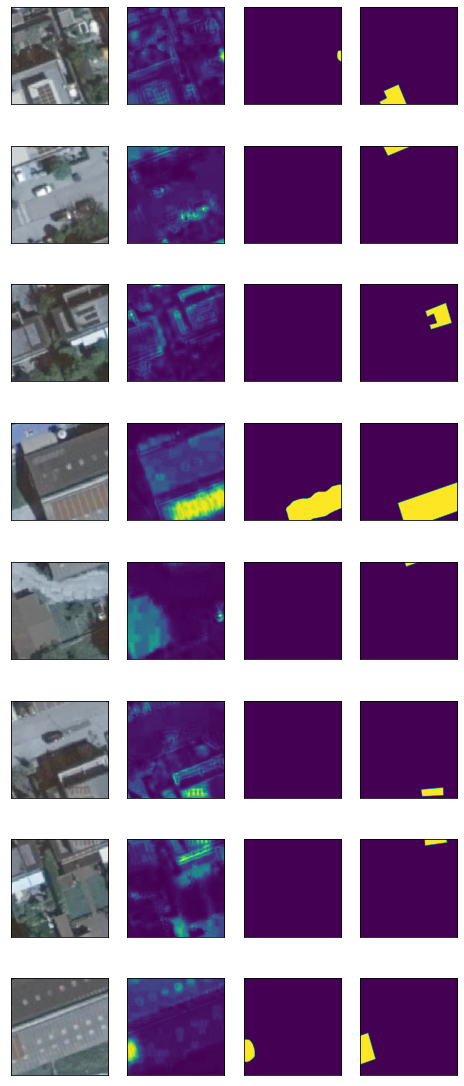

In [16]:
test_input_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\test\A",
]
test_output_dirs = [
    r"D:\DELFT\Q4 GEO1101 Synthesis\ML\solar_panels\qgis_export\run3\rgb_pairs\20\test\B",
]

test_input_imgs = load_images(test_input_dirs)
test_output_imgs = load_images(test_output_dirs, crop=output_shape, BW=True)

# Infer a result
image_indexes = [i for i,_ in enumerate(test_input_imgs)]

# Plotting
fig, axs = plt.subplots(len(image_indexes), 4)
fig.set_size_inches(8,20)

for i, index in enumerate(image_indexes):
    inp = test_input_imgs[index].reshape(1, 256, 256, 3)
    infer = model.predict(inp).reshape(246, 246)

    axs[i,0].imshow(test_input_imgs[index])
    axs[i,1].imshow(infer)
    axs[i,2].imshow(process_inference(infer))
    axs[i,3].imshow(test_output_imgs[index].reshape(246, 246))

    for ax in axs.flat:
        hide_axis(ax)